In [58]:
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import datasets
from scipy.spatial import distance
import networkx as nx

In [59]:
base_color = 'darkturquoise'


* Use The 20 newsgroups text dataset. See http://scikit-learn.org/stable/datasets/twenty_newsgroups.html#newsgroups

In [60]:
categories = ['rec.sport.baseball', 'sci.space']
train = datasets.fetch_20newsgroups(subset='train', categories=categories)
valid = datasets.fetch_20newsgroups(subset='test', categories=categories)

train.data = np.array(train.data, dtype=np.object)
valid.data = np.array(valid.data, dtype=np.object)

In [61]:
len(train.data), len(train.target), len(valid.data), len(valid.target)

(1190, 1190, 791, 791)

In [62]:
indices = np.where(train.target == 0)
len(train.data[indices])

597

In [63]:
indices = np.where(train.target == 1)
len(train.data[indices])

593

In [64]:
# see http://xpo6.com/list-of-english-stop-words/

stopwords = [
    "a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all",
    "almost", "alone", "along", "already", "also","although","always","am","among", "amongst",
    "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway",
    "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes",
    "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between",
    "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could",
    "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight",
    "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for",
    "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had",
    "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers",
    "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", 
    "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many",
    "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much",
    "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody",
    "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only",
    "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per",
    "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious",
    "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", 
    "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten",
    "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though",
    "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well",
    "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole",
    "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours",
    "yourself", "yourselves", "the",
    
    "edu", "subject", "com"
]

In [65]:
def analyzer(text):
    
    text = text.lower() # 小文字化
    text = text.replace('\n', '') # 改行削除
    text = text.replace('\t', '') # タブ削除
    text = re.sub(re.compile(r'[!-\/:-@[-`{-~]'), ' ', text) # 記号をスペースに置き換え
    text = text.split(' ') # スペースで区切る
    
    words = []
    for word in text:
        if (re.compile(r'^.*[0-9]+.*$').fullmatch(word) is not None): # 数字が含まれるものは除外
            continue
        if word in stopwords: # ストップワードに含まれるものは除外
            continue
        if len(word) < 2: #  1文字、0文字（空文字）は除外
            continue
        words.append(word)
        
    return words

In [127]:
indices = np.where(train.target == 0)
corpus = train.data[indices]

vectorizer = CountVectorizer(analyzer=analyzer, min_df=0.1)#, max_df=0.9)
vectorizer.fit_transform(corpus)

<597x80 sparse matrix of type '<class 'numpy.int64'>'
	with 8500 stored elements in Compressed Sparse Row format>

In [128]:
vectorizer.transform(corpus).toarray().shape, len(vectorizer.get_feature_names())

((597, 80), 80)

In [129]:
word_counts = vectorizer.transform(corpus).toarray()
word_counts = np.sum(word_counts, axis=0)
df_word_counts = pd.DataFrame({'word': vectorizer.get_feature_names(), 'cnt': word_counts})
len(df_word_counts)

80

In [130]:
df_word_counts[['cnt']].describe()

,cnt
count,80.000000
mean,157.987500
std,89.121947
min,72.000000
25%,96.750000
50%,122.500000
75%,203.000000
max,467.000000


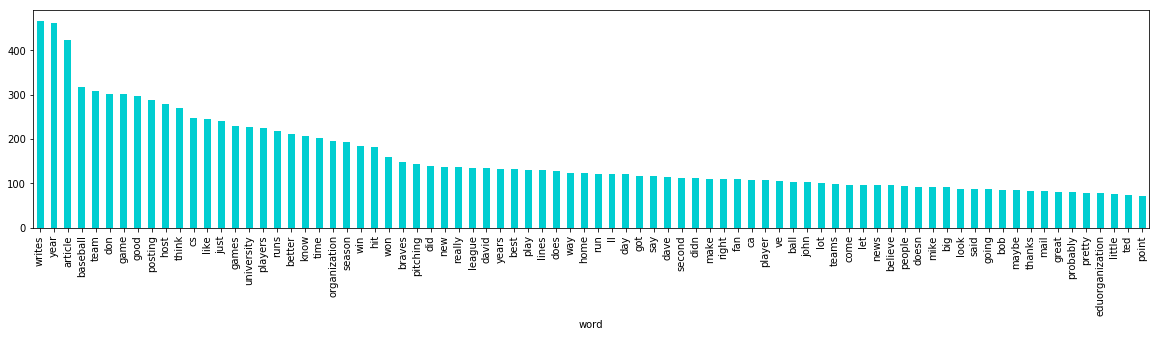

In [131]:
df_word_counts.sort_values(by='cnt', ascending=False) \
    .plot(kind='bar', x='word', y='cnt', figsize=(20,4), color=base_color, legend=False)
plt.show()

In [132]:
df_word_counts['zipf'] = (df_word_counts.index.values+1)*df_word_counts['cnt']

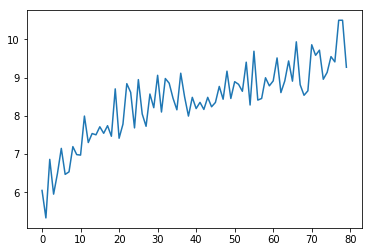

In [133]:
np.log(df_word_counts['zipf']).plot()
plt.show()

In [147]:
# 共起数を数える

vocab_num = len(vectorizer.get_feature_names())
combination_matrix = np.zeros((vocab_num, vocab_num))

for word_cnt_vec in vectorizer.transform(corpus).toarray():
    word_pair_indices = list(itertools.combinations(np.where(word_cnt_vec != 0)[0], 2)) # 共起ペアのリスト
    for i, j in word_pair_indices:
        combination_matrix[i, j] += 1
        combination_matrix[j, i] += 1
        
combination_matrix.shape, combination_matrix.max()

((80, 80), 274.0)

In [152]:
# 共起頻度

nodes = []
vocabs = vectorizer.get_feature_names()
thresh = np.sort(combination_matrix.reshape(-1))[::-1][100]

for i in range(vocab_num):
    for j in range(i+1, vocab_num):
        
        comb_cnts = combination_matrix[i, j]
        if comb_cnts >= thresh:
            nodes.append([vocabs[i], vocabs[j], word_counts[i], word_counts[j], comb_cnts])
            
print('Node count: {}'.format(len(nodes)))

Node count: 51


In [158]:
def plot_cooccurrence_network(nodes, node_size_rate, edge_weight_rate):
        
    G = nx.Graph()
    G.nodes(data=True)

    for pair in nodes:

        node_x, node_y, node_x_cnt, node_y_cnt, w = pair[0], pair[1], pair[2], pair[3], pair[4]

        if not G.has_node(node_x):
            G.add_node(node_x, count=node_x_cnt)
        if not G.has_node(node_y):
            G.add_node(node_y, count=node_y_cnt)
        if not G.has_edge(node_x, node_y):
            G.add_edge(node_x, node_y, weight=w)

    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(G, k=5.0)

    node_size = [d['count']*node_size_rate for (n,d) in G.nodes(data=True)]
    nx.draw_networkx_nodes(G, pos, node_color=base_color, alpha=0.8, node_size=node_size)
    nx.draw_networkx_labels(G, pos, fontsize=14)

    edge_width = [d['weight']*edge_weight_rate for (u,v,d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='black', width=edge_width)

    plt.axis('off')
    plt.show()

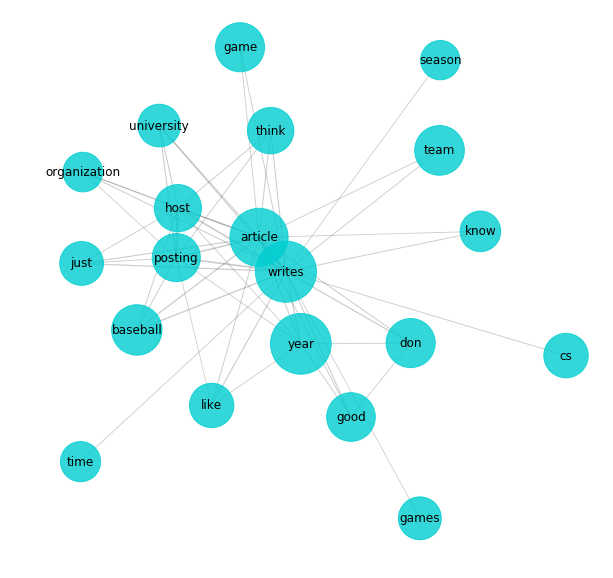

In [160]:
plot_cooccurrence_network(nodes, node_size_rate=8, edge_weight_rate=0.01)

In [161]:
# jaccard係数

jaccard_matrix = 1-distance.cdist(combination_matrix, combination_matrix, 'jaccard')
jaccard_matrix

array([[ 1.    ,  0.    ,  0.0125, ...,  0.0125,  0.    ,  0.    ],
       [ 0.    ,  1.    ,  0.    , ...,  0.    ,  0.    ,  0.05  ],
       [ 0.0125,  0.    ,  1.    , ...,  0.    ,  0.0375,  0.    ],
       ..., 
       [ 0.0125,  0.    ,  0.    , ...,  1.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.0375, ...,  0.    ,  1.    ,  0.    ],
       [ 0.    ,  0.05  ,  0.    , ...,  0.    ,  0.    ,  1.    ]])

In [171]:
nodes = []
vocabs = vectorizer.get_feature_names()
thresh = np.sort(jaccard_matrix.reshape(-1))[::-1][150]

for i in range(vocab_num):
    for j in range(i+1, vocab_num):
        jaccard = jaccard_matrix[i, j]
        if jaccard > thresh:
            nodes.append([vocabs[i], vocabs[j], word_counts[i], word_counts[j], jaccard])

print('Node count: {}'.format(len(nodes)))

Node count: 32


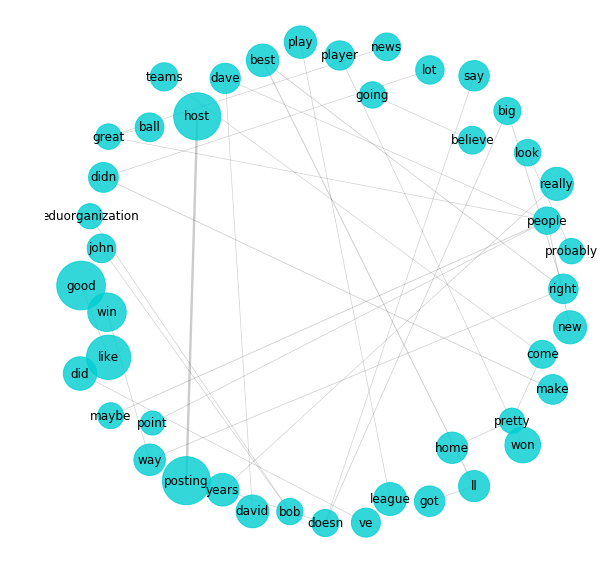

In [172]:
plot_cooccurrence_network(nodes, node_size_rate=8, edge_weight_rate=5)

In [175]:
# category = sci.space

indices = np.where(train.target == 1)
corpus = train.data[indices]

vectorizer = CountVectorizer(analyzer=analyzer, min_df=0.1)
vectorizer.fit_transform(corpus)

word_counts = vectorizer.transform(corpus).toarray()
word_counts = np.sum(word_counts, axis=0)
df_word_counts = pd.DataFrame({'word': vectorizer.get_feature_names(), 'cnt': word_counts})

vocab_num = len(vectorizer.get_feature_names())
combination_matrix = np.zeros((vocab_num, vocab_num))

for word_cnt_vec in vectorizer.transform(corpus).toarray():
    word_pair_indices = list(itertools.combinations(np.where(word_cnt_vec != 0)[0], 2)) # 共起ペアのリスト
    for i, j in word_pair_indices:
        combination_matrix[i, j] += 1
        combination_matrix[j, i] += 1
        
for i in range(vocab_num):
    combination_matrix[i, i] /= 2
    
jaccard_matrix = 1-distance.cdist(combination_matrix, combination_matrix, 'jaccard')

nodes = []
vocabs = vectorizer.get_feature_names()
thresh = np.sort(jaccard_matrix.reshape(-1))[::-1][200]

for i in range(vocab_num):
    for j in range(i+1, vocab_num):
        jaccard = jaccard_matrix[i, j]
        if jaccard > thresh:
            nodes.append([vocabs[i], vocabs[j], word_counts[i], word_counts[j], jaccard])

print('Node count: {}'.format(len(nodes)))

Node count: 35


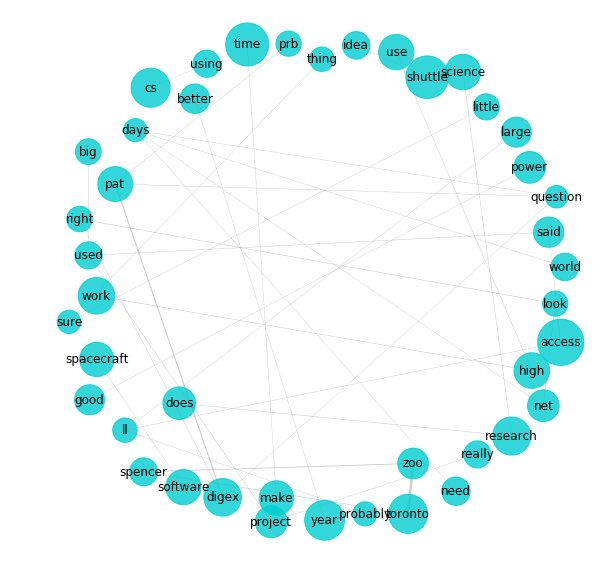

In [176]:
plot_cooccurrence_network(nodes, node_size_rate=8, edge_weight_rate=3)

In [60]:
!python --version

Python 3.6.6


In [61]:
!pip freeze

alembic==0.9.9
asn1crypto==0.24.0
attrs==18.1.0
Automat==0.0.0
backcall==0.1.0
beautifulsoup4==4.6.1
bleach==2.1.3
bokeh==0.12.16
boto==2.49.0
boto3==1.7.71
botocore==1.10.71
bz2file==0.98
certifi==2018.4.16
cffi==1.11.5
chardet==3.0.4
cloudpickle==0.5.3
conda==4.5.8
constantly==15.1.0
cryptography==2.2.1
cycler==0.10.0
Cython==0.28.5
dask==0.18.2
decorator==4.3.0
dill==0.2.8.2
docutils==0.14
entrypoints==0.2.3
fastcache==1.0.2
gensim==3.5.0
gmpy2==2.0.8
h5py==2.7.1
html5lib==1.0.1
hyperlink==17.3.1
idna==2.7
imageio==2.3.0
incremental==17.5.0
ipykernel==4.8.2
ipython==6.5.0
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.1
Jinja2==2.10
jmespath==0.9.3
jsonschema==2.6.0
jupyter-client==5.2.3
jupyter-core==4.4.0
jupyterhub==0.8.1
jupyterlab==0.33.4
jupyterlab-launcher==0.11.2
kiwisolver==1.0.1
llvmlite==0.23.0
Mako==1.0.7
MarkupSafe==1.0
matplotlib==2.2.2
mecab-python3==0.7
mistune==0.8.3
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
notebook==5.6.0
numba==0.38.1
numexpr==2.6.6
nu